In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import cv2
import time
import re
import itertools
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import pairwise_distances, accuracy_score, precision_recall_fscore_support, roc_auc_score

In [ ]:
# Configurations
DATASET_ROOT = "dataset_final"  
IMAGE_SIZE = (128, 128)
K = 200  # number of visual words for SIFT BoVW
TFIDF_MAX = 50
PCA_DIM = 200

CLASSES = ["apple", "cucumber", "eggplant", "banana", "tangerine"]
random_seed = 42
np.random.seed(42)

In [3]:
# Class categorical data
ORIGIN_MAP = {
    "banana": [
        "Mediterranean", "SoutheasternAnatolia", "Aegean", "CoastalMediterranean",
        "InnerMediterranean", "UpperMesopotamia", "TropicalImport",
        "SubtropicalImport", "CoastalValley", "RiverBasinRegion"
    ],
    "apple": [
        "BlackSea", "CentralAnatolia", "EasternAnatolia", "WesternAnatolia",
        "InnerAegean", "MountainRegion", "HighlandPlateau", "ValleyRegion",
        "ContinentalInterior", "RiverValley"
    ],
    "cucumber": [
        "Marmara", "Aegean", "Mediterranean", "Thrace", "WesternAnatolia",
        "GreenhouseRegion", "RiverBasinRegion", "CoastalPlain", "LowlandRegion"
    ],
    "eggplant": [
        "Mediterranean", "Aegean", "SoutheasternAnatolia", "TaurusRegion",
        "UpperMesopotamia", "CoastalValley", "AlluvialPlain",
        "WesternAnatolia", "DeltaRegion"
    ],
    "tangerine": [
        "Mediterranean", "Aegean", "InnerAegean", "CoastalMediterranean",
        "LowlandCoastal", "RiverDeltaRegion", "SubtropicalCoastal",
        "GulfRegion", "WarmValley"
    ]
}

CLIMATE_MAP = {
    "banana": [
        "MediterraneanClimate", "HumidSubtropical", "TropicalLikeClimate",
        "TemperateClimate", "WarmCoastalClimate", "SemiAridClimate",
        "ValleyMicroclimate"
    ],
    "apple": [
        "ContinentalClimate", "BlackSeaClimate", "HighlandClimate",
        "SteppeClimate", "TemperateClimate", "MountainClimate"
    ],
    "cucumber": [
        "TemperateClimate", "MediterraneanClimate", "DryClimate",
        "SemiAridClimate", "ControlledClimate", "MildCoastalClimate"
    ],
    "eggplant": [
        "SemiAridClimate", "ContinentalClimate", "MediterraneanClimate",
        "TemperateClimate", "DryClimate", "ValleyMicroclimate"
    ],
    "tangerine": [
        "MediterraneanClimate", "HumidSubtropical", "TemperateClimate",
        "WarmCoastalClimate", "MildWinterClimate"
    ]
}

HARVEST_MAP = {
    "banana": [
        "EarlySummer", "MidSummer", "LateSummer",
        "EarlyAutumn", "PeakSeason", "OffSeason"
    ],
    "apple": [
        "EarlyAutumn", "MidAutumn", "LateAutumn",
        "EarlyWinter", "MidWinterStorage", "PeakSeason"
    ],
    "cucumber": [
        "EarlySpring", "MidSpring", "LateSpring",
        "EarlySummer", "MidSummer", "PeakSeason"
    ],
    "eggplant": [
        "LateSpring", "EarlySummer", "MidSummer",
        "LateSummer", "EarlyAutumn", "PeakSeason"
    ],
    "tangerine": [
        "EarlyAutumn", "MidAutumn", "LateAutumn",
        "EarlyWinter", "WinterHarvest", "MidWinter", "PeakSeason"
    ]
}

ALL_ORIGINS = sorted(set(itertools.chain.from_iterable(ORIGIN_MAP.values())))
ALL_CLIMATES = sorted(set(itertools.chain.from_iterable(CLIMATE_MAP.values())))
ALL_HARVESTS = sorted(set(itertools.chain.from_iterable(HARVEST_MAP.values())))

def assign_metadata(label: str, p_class_specific: float = 0.75):
    """
    We assign real categorical data on the dataset with a probability of p_class_specific.
    Otherwise, we sample from the global pool randomly. It creates some noise in the dataset.
    """
    if random.random() < p_class_specific:
        origin  = random.choice(ORIGIN_MAP[label])
        climate = random.choice(CLIMATE_MAP[label])
        harvest = random.choice(HARVEST_MAP[label])
    else:
        origin  = random.choice(ALL_ORIGINS)
        climate = random.choice(ALL_CLIMATES)
        harvest = random.choice(ALL_HARVESTS)
    return origin, climate, harvest

In [4]:
# Feature extraction
sift = cv2.SIFT_create()

def extract_sift_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    return np.zeros((1, 128)) if des is None else des

def build_bovw(desc_list, k=K):
    all_desc = np.vstack(desc_list)
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=5000, random_state=42)
    kmeans.fit(all_desc)
    return kmeans

def sift_hist(des, kmeans):
    labels = kmeans.predict(des)
    hist, _ = np.histogram(labels, bins=K, range=(0, K), density=True)
    return hist

def extract_hog(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return hog(gray, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm="L2-Hys",
               transform_sqrt=True, feature_vector=True)

def extract_hsv_hist(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = cv2.calcHist([hsv],[0],None,[32],[0,180])
    s = cv2.calcHist([hsv],[1],None,[16],[0,256])
    v = cv2.calcHist([hsv],[2],None,[16],[0,256])
    hist = np.concatenate([h,s,v]).flatten()
    return hist / (np.sum(hist)+1e-12)

def extract_lbp(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    hist, _ = np.histogram(lbp, bins=59, range=(0,59), density=True)
    return hist

def extract_hu(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m = cv2.moments(gray)
    hu = cv2.HuMoments(m).flatten()
    return -np.sign(hu)*np.log10(np.abs(hu)+1e-12)

def extract_combined(img, kmeans):
    hog_feat = extract_hog(img)
    hsv_feat = extract_hsv_hist(img)
    lbp_feat = extract_lbp(img)
    hu_feat = extract_hu(img)
    des = extract_sift_descriptors(img)
    bovw = sift_hist(des, kmeans)
    return np.concatenate([hog_feat, hsv_feat, lbp_feat, hu_feat, bovw])

In [5]:
# Dataset loader
def load_dataset(root):
    img_paths, labels = [], []
    for cls in CLASSES:
        folder = os.path.join(root, cls)
        for f in os.listdir(folder):
            if f.lower().endswith((".png")):
                img_paths.append(os.path.join(folder,f))
                labels.append(cls)
    return img_paths, labels

# Image loader
def load_images(paths, name):
    imgs = []
    broken = 0
    for p in tqdm(paths, desc=f"{name} images"):
        img = cv2.imread(p)
        imgs.append(cv2.resize(img, IMAGE_SIZE))
    print(f" {name}: {len(imgs)} loaded")
    return imgs

# Text loader
def load_texts(image_paths, text_root="dataset_text"):
    texts = []
    
    # Our text model gave lots of "orange" instead of "tangerine"
    # So we mask "orange" as well
    mask_roots = ["apple", "banana", "cucumber", "tangerine", "eggplant", "orange"]

    mask_pattern = re.compile(
        r"\b(" + "|".join(mask_roots) + r")[a-zA-Z]*\b",
        flags=re.IGNORECASE
    )

    for p in image_paths:
        cls = os.path.basename(os.path.dirname(p))
        fname = os.path.splitext(os.path.basename(p))[0] + ".txt"
        text_path = os.path.join(text_root, cls, fname)

        if not os.path.exists(text_path):
            print(" MISSING TEXT:", text_path)
            texts.append("")
            continue

        with open(text_path, "r", encoding="utf-8") as f:
            raw_text = f.read()

        masked_text = mask_pattern.sub("<mask>", raw_text)
        texts.append(masked_text)
    return texts

In [6]:
# 1. Loading Data
t0 = time.time() # Initial time

print("[1/12] Loading dataset...")
paths, labels = load_dataset(DATASET_ROOT)
metadata = [assign_metadata(lbl) for lbl in labels]

print(f" Total samples: {len(paths)}")
print(f" Unique classes: {len(set(labels))}")

[1/12] Loading dataset...
 Total samples: 3092
 Unique classes: 5


In [7]:
# 2. Splitting dataset
print("\n[2/12] Splitting dataset...")

(p_trainval, p_test,
    y_trainval, y_test,
    meta_trainval, meta_test) = train_test_split(
    paths, labels, metadata,
    test_size=0.2, random_state=42, stratify=labels
)

(p_train, p_val,
    y_train, y_val,
    meta_train, meta_val) = train_test_split(
    p_trainval, y_trainval, meta_trainval,
    test_size=0.25, random_state=42, stratify=y_trainval
)

print(f" TRAIN: {len(p_train)}")
print(f" VAL:   {len(p_val)}")
print(f" TEST:  {len(p_test)}")


[2/12] Splitting dataset...
 TRAIN: 1854
 VAL:   619
 TEST:  619


In [8]:
# 3. Loading images
print("\n[3/12] Loading images...")

X_train_imgs = load_images(p_train, "TRAIN")
X_val_imgs   = load_images(p_val,   "VAL")
X_test_imgs  = load_images(p_test,  "TEST")


[3/12] Loading images...


TRAIN images: 100%|██████████| 1854/1854 [02:03<00:00, 14.95it/s]


 TRAIN: 1854 loaded


VAL images: 100%|██████████| 619/619 [00:40<00:00, 15.45it/s]


 VAL: 619 loaded


TEST images: 100%|██████████| 619/619 [00:45<00:00, 13.56it/s]

 TEST: 619 loaded


In [9]:
# 4. Learning SIFT → BoVW
print("\n[4/12] Extracting SIFT descriptors...")

train_desc = [extract_sift_descriptors(img) for img in tqdm(X_train_imgs, desc="SIFT")]
kmeans = build_bovw(train_desc, K)


[4/12] Extracting SIFT descriptors...


SIFT: 100%|██████████| 1854/1854 [00:14<00:00, 123.64it/s]


In [10]:
# 5. Extracting image features
print("\n[5/12] Extracting image features...")

X_train_num = np.vstack([extract_combined(img, kmeans) for img in tqdm(X_train_imgs)])
X_val_num   = np.vstack([extract_combined(img, kmeans) for img in tqdm(X_val_imgs)])
X_test_num  = np.vstack([extract_combined(img, kmeans) for img in tqdm(X_test_imgs)])

print(" Image feature shapes:")
print("   TRAIN:", X_train_num.shape)
print("   VAL:  ", X_val_num.shape)
print("   TEST: ", X_test_num.shape)


[5/12] Extracting image features...


100%|██████████| 619/619 [00:08<00:00, 73.62it/s]


 Image feature shapes:
   TRAIN: (1854, 8430)
   VAL:   (619, 8430)
   TEST:  (619, 8430)


In [11]:
# 6. Encoding categorical data
print("\n[6/12] Encoding categorical data...")
enc = OneHotEncoder(sparse_output=True, handle_unknown="ignore")

X_train_cat = enc.fit_transform(meta_train)
X_val_cat   = enc.transform(meta_val)
X_test_cat  = enc.transform(meta_test)

n_cat = X_train_cat.shape[1]
print(" Categorical features:", n_cat)


[6/12] Encoding categorical data...
 Categorical features: 64


In [12]:
# 7. Encoding text data
print("\n[7/12] Encoding text data...")

train_texts = load_texts(p_train, "dataset_text")
val_texts   = load_texts(p_val,   "dataset_text")
test_texts  = load_texts(p_test,  "dataset_text")

tfidf = TfidfVectorizer(
    max_features=TFIDF_MAX,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_txt = tfidf.fit_transform(train_texts)
X_val_txt   = tfidf.transform(val_texts)
X_test_txt  = tfidf.transform(test_texts)

n_txt = X_train_txt.shape[1]
print(" Text features:", n_txt)


[7/12] Encoding text data...
 Text features: 50


In [13]:
# Method for similarity and outlier analysis (inter-intra class)
def analyze_feature_block(X_block, y_block, name):
    print(f"-> Analyzing {name} features")

    D = pairwise_distances(X_block, metric="cosine")
    classes = np.unique(y_block)

    # Intra-class similarity
    intra = {}
    for c in classes:
        idx = np.where(y_block == c)[0]
        intra[c] = 1 - np.mean(D[np.ix_(idx, idx)])

    print("\nIntra-class similarities:")
    for k, v in intra.items():
        print(f"  Class {k}: {v:.4f}")

    # Inter-class similarity
    inter = {}
    print("\nInter-class similarities:")
    for i, c1 in enumerate(classes):
        for c2 in classes[i+1:]:
            idx1 = np.where(y_block == c1)[0]
            idx2 = np.where(y_block == c2)[0]
            inter[(c1,c2)] = 1 - np.mean(D[np.ix_(idx1, idx2)])
            print(f"  Class pair {c1} vs {c2}: {inter[(c1,c2)]:.4f}")

    # Outlier detection
    outliers = defaultdict(list)
    for c in classes:
        idx = np.where(y_block == c)[0]
        md = D[np.ix_(idx, idx)].mean(axis=1)
        thr = md.mean() + 2 * md.std()
        outliers[c] = idx[md > thr].tolist()

    print("\nDetected outliers per class:")
    for k, v in outliers.items():
        print(f"  Class {k}: {len(v)} outliers")

    # Dataset difficulty
    mean_intra = np.mean(list(intra.values()))
    mean_inter = np.mean(list(inter.values()))
    difficulty_ratio = mean_inter / mean_intra

    print("\nDataset difficulty summary:")
    print(f"  Mean intra-class similarity: {mean_intra:.4f}")
    print(f"  Mean inter-class similarity: {mean_inter:.4f}")
    print(f"  Separation ratio (inter / intra): {difficulty_ratio:.4f}")

    return intra, inter, outliers, difficulty_ratio

In [14]:
# 8. Similarity and outlier analysis (inter-intra class)
print("\n[8/12] Running similarity & outlier analysis...")

y_used = np.concatenate([y_train, y_val])

X_img = np.vstack([X_train_num, X_val_num])
X_txt = np.vstack([X_train_txt.toarray(), X_val_txt.toarray()])
X_cat = np.vstack([X_train_cat.toarray(), X_val_cat.toarray()])

img_stats   = analyze_feature_block(X_img, y_used, "IMAGE")
txt_stats   = analyze_feature_block(X_txt, y_used, "TEXT")
cat_stats   = analyze_feature_block(X_cat, y_used, "CATEGORICAL")

# Fused feature analysis (concatenation)
X_fused = np.hstack([X_img, X_txt, X_cat])
fused_stats = analyze_feature_block(X_fused, y_used, "FUSED (IMAGE + TEXT + CATEGORICAL)")


[8/12] Running similarity & outlier analysis...
-> Analyzing IMAGE features

Intra-class similarities:
  Class apple: 0.4658
  Class banana: 0.4623
  Class cucumber: 0.4577
  Class eggplant: 0.4876
  Class tangerine: 0.4587

Inter-class similarities:
  Class pair apple vs banana: 0.4553
  Class pair apple vs cucumber: 0.4536
  Class pair apple vs eggplant: 0.4710
  Class pair apple vs tangerine: 0.4575
  Class pair banana vs cucumber: 0.4580
  Class pair banana vs eggplant: 0.4575
  Class pair banana vs tangerine: 0.4567
  Class pair cucumber vs eggplant: 0.4583
  Class pair cucumber vs tangerine: 0.4538
  Class pair eggplant vs tangerine: 0.4577

Detected outliers per class:
  Class apple: 10 outliers
  Class banana: 16 outliers
  Class cucumber: 14 outliers
  Class eggplant: 12 outliers
  Class tangerine: 15 outliers

Dataset difficulty summary:
  Mean intra-class similarity: 0.4664
  Mean inter-class similarity: 0.4579
  Separation ratio (inter / intra): 0.9818
-> Analyzing TEXT fe

In [15]:
# Our lovely logistic regression model
class CanAndBeyzaLogisticRegression:
    def __init__(self, C=1.0, max_iter=1000, tol=1e-4, learning_rate=0.01, 
                 use_adaptive_lr=True, verbose=False, record_history=False):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.use_adaptive_lr = use_adaptive_lr
        self.verbose = verbose
        self.record_history = record_history

        self.weights = None
        self.bias = None
        self.classes_ = None

        self.train_loss_history_ = None
        self.val_loss_history_ = None
        
    def _sigmoid(self, z):
        return np.where(
            z >= 0,
            1 / (1 + np.exp(-z)),
            np.exp(z) / (1 + np.exp(z))
        )
    
    def _softmax(self, z):
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        proba = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        return proba
    
    def _compute_loss(self, X, y, weights, bias):
        n = X.shape[0]
        z = X @ weights + bias
        p = self._sigmoid(z)

        p = np.clip(p, 1e-15, 1 - 1e-15)
        ce_loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

        # L2 regularization
        # Scale reg by n so that C behaves like in scikit-learn
        reg_term = (1 / (2 * self.C * n)) * np.sum(weights ** 2)

        return ce_loss + reg_term

    def _compute_gradients(self, X, y, weights, bias):
        n = X.shape[0]
        z = X @ weights + bias
        p = self._sigmoid(z)

        data_grad = (X.T @ (p - y)) / n
        reg_grad = (1 / (self.C * n)) * weights

        dw = data_grad + reg_grad
        db = np.mean(p - y)

        return dw, db

    def _fit_binary(self, X, y, X_val=None, y_val=None, class_key=None):
        n, d = X.shape
        
        weights = np.zeros(d)
        bias = 0.0
        
        if self.record_history:
            train_losses = []
            val_losses = []
        
        # Adaptive learning rate setup
        current_lr = self.learning_rate
        patience = 10
        best_loss = float('inf')
        patience_counter = 0
        
        for iteration in range(self.max_iter):
            dw, db = self._compute_gradients(X, y, weights, bias)
            
            weights -= current_lr * dw
            bias -= current_lr * db
            
            train_loss = self._compute_loss(X, y, weights, bias)
            
            if self.record_history:
                train_losses.append(train_loss)
                if X_val is not None and y_val is not None:
                    val_loss = self._compute_loss(X_val, y_val, weights, bias)
                    val_losses.append(val_loss)
            
            if self.use_adaptive_lr:
                if train_loss < best_loss - self.tol:
                    best_loss = train_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= patience:
                    current_lr *= 0.5
                    patience_counter = 0
                    if self.verbose and iteration % 100 == 0:
                        print(f"    Iteration {iteration}: Reducing LR to {current_lr:.6f}")
                
                if current_lr < 1e-8:
                    if self.verbose:
                        print(f"    Stopping early at iteration {iteration}: LR too small")
                    break
        
        if self.record_history:
            if isinstance(self.train_loss_history_, dict) and class_key is not None:
                self.train_loss_history_[class_key] = train_losses
                if X_val is not None and y_val is not None:
                    self.val_loss_history_[class_key] = val_losses
            else:
                self.train_loss_history_ = train_losses
                if X_val is not None and y_val is not None:
                    self.val_loss_history_ = val_losses
        
        return weights, bias
    
    def fit(self, X, y, X_val=None, y_val=None):
        X = np.asarray(X)
        y = np.asarray(y)

        if X_val is not None and y_val is not None:
            X_val = np.asarray(X_val)
            y_val = np.asarray(y_val)
        
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        
        n, d = X.shape
        self.weights = np.zeros((d, n_classes))
        self.bias = np.zeros(n_classes)

        if self.record_history:
            self.train_loss_history_ = {}
            self.val_loss_history_ = {} if X_val is not None else None
        
        for i, cls in enumerate(self.classes_):
            if self.verbose:
                print(f"[OvA {i+1}/{n_classes}] Training '{cls}' vs. all others...")
            else:
                print(f"[OvA {i+1}/{n_classes}] Training classifier for '{cls}'")
            
            y_binary = (y == cls).astype(float)
            
            n_pos = np.sum(y_binary)
            n_neg = len(y_binary) - n_pos
            if self.verbose:
                print(f"  Positive samples: {n_pos}, Negative samples: {n_neg}")
            
            if X_val is not None and y_val is not None:
                y_val_binary = (y_val == cls).astype(float)
            else:
                y_val_binary = None
            
            self.weights[:, i], self.bias[i] = self._fit_binary(
                X, y_binary,
                X_val=X_val,
                y_val=y_val_binary,
                class_key=cls
            )
            print(f"Classifier for '{cls}' trained successfully\n")
        
        return self
    
    def predict_proba(self, X):
        X = np.asarray(X)
        scores = X @ self.weights + self.bias
        return self._softmax(scores)

    def predict(self, X):
        X = np.asarray(X)
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

[9/12] Training our LogReg classifier per modality
Scaling all feature modalities...
Fused feature shape: (1854, 314)
[Modality: Images only] Grid-search over C
  Using learning_rate=0.01, max_iter=1000
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggplant'
Classifier for 'eggplant' trained successfully

[OvA 5/5] Training classifier for 'tangerine'
Classifier for 'tangerine' trained successfully

  C = 0.01   → VAL acc = 0.6333
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggp

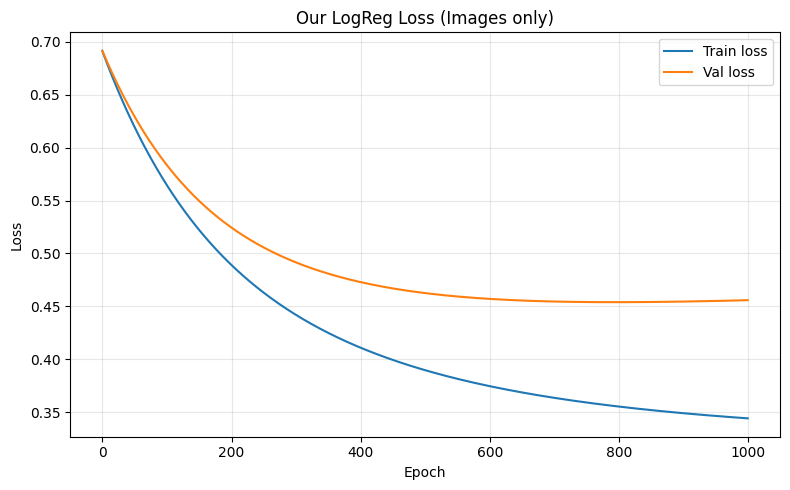

Saved loss plot to: our_logreg_loss_images_only.png
[Modality: Categorical only] Grid-search over C
  Using learning_rate=0.01, max_iter=1000
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggplant'
Classifier for 'eggplant' trained successfully

[OvA 5/5] Training classifier for 'tangerine'
Classifier for 'tangerine' trained successfully

  C = 0.01   → VAL acc = 0.7108
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggplant'
Classifier for 'eggplant' trained successfully

[OvA 5/

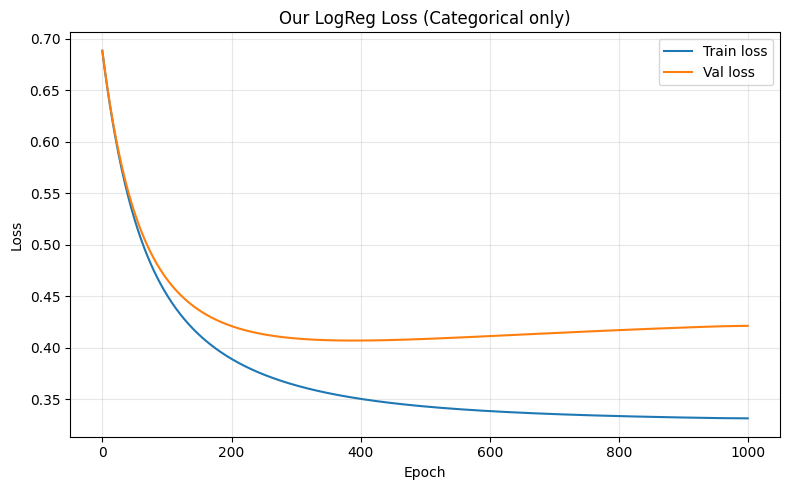

Saved loss plot to: our_logreg_loss_categorical_only.png
[Modality: Text only] Grid-search over C
  Using learning_rate=0.01, max_iter=1000
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggplant'
Classifier for 'eggplant' trained successfully

[OvA 5/5] Training classifier for 'tangerine'
Classifier for 'tangerine' trained successfully

  C = 0.01   → VAL acc = 0.7431
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggplant'
Classifier for 'eggplant' trained successfully

[OvA 5/5]

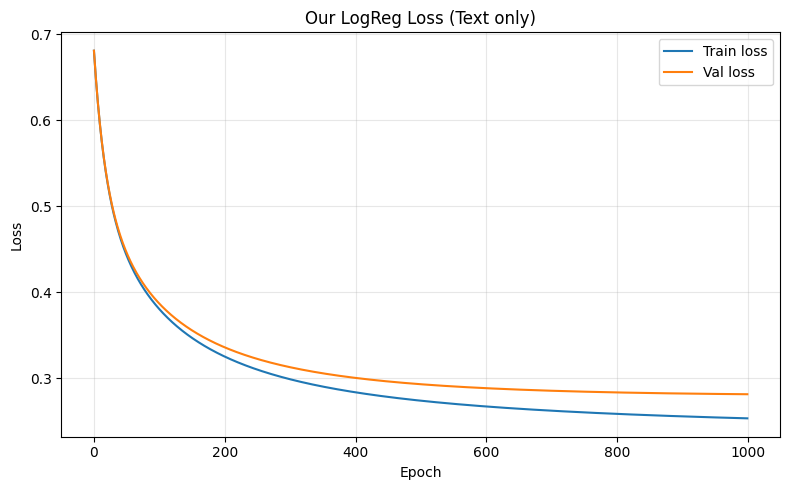

Saved loss plot to: our_logreg_loss_text_only.png
[Modality: Fused (image + metadata + text)] Grid-search over C
  Using learning_rate=0.005, max_iter=2000
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggplant'
Classifier for 'eggplant' trained successfully

[OvA 5/5] Training classifier for 'tangerine'
Classifier for 'tangerine' trained successfully

  C = 0.01   → VAL acc = 0.8853
[OvA 1/5] Training classifier for 'apple'
Classifier for 'apple' trained successfully

[OvA 2/5] Training classifier for 'banana'
Classifier for 'banana' trained successfully

[OvA 3/5] Training classifier for 'cucumber'
Classifier for 'cucumber' trained successfully

[OvA 4/5] Training classifier for 'eggplant'
Classifier for 'eggplant' trained success

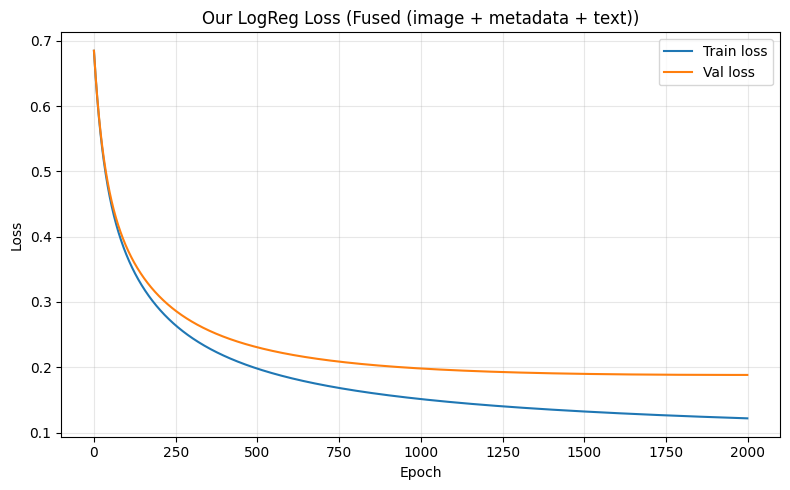

Saved loss plot to: our_logreg_loss_fused_(image_+_metadata_+_text).png


In [16]:
# 9. Training our LogReg classifier per modality
print("[9/12] Training our LogReg classifier per modality")

scaler = StandardScaler()

X_train_num_s = scaler.fit_transform(X_train_num)
X_val_num_s   = scaler.transform(X_val_num)
X_test_num_s  = scaler.transform(X_test_num)

pca_val = PCA(
    n_components=PCA_DIM,
    svd_solver="randomized",
    random_state=42
)

X_train_pca = pca_val.fit_transform(X_train_num_s)
X_val_pca   = pca_val.transform(X_val_num_s)
X_test_pca  = pca_val.transform(X_test_num_s)

# Scale ALL features properly
print("Scaling all feature modalities...")

# Image features
scaler_img = StandardScaler()
X_train_img = scaler_img.fit_transform(X_train_pca)
X_val_img   = scaler_img.transform(X_val_pca)
X_test_img  = scaler_img.transform(X_test_pca)

# Categorical features (scale without centering)
scaler_cat = StandardScaler(with_mean=False)
X_train_meta = scaler_cat.fit_transform(X_train_cat)
X_val_meta   = scaler_cat.transform(X_val_cat)
X_test_meta  = scaler_cat.transform(X_test_cat)

X_train_meta = X_train_meta.toarray() if hasattr(X_train_meta, 'toarray') else X_train_meta
X_val_meta   = X_val_meta.toarray() if hasattr(X_val_meta, 'toarray') else X_val_meta
X_test_meta  = X_test_meta.toarray() if hasattr(X_test_meta, 'toarray') else X_test_meta

# Text features (scale without centering)
scaler_txt = StandardScaler(with_mean=False)
X_train_text = scaler_txt.fit_transform(X_train_txt)
X_val_text   = scaler_txt.transform(X_val_txt)
X_test_text  = scaler_txt.transform(X_test_txt)

X_train_text = X_train_text.toarray() if hasattr(X_train_text, 'toarray') else X_train_text
X_val_text   = X_val_text.toarray() if hasattr(X_val_text, 'toarray') else X_val_text
X_test_text  = X_test_text.toarray() if hasattr(X_test_text, 'toarray') else X_test_text

# Fused features
X_train_fused = np.hstack([X_train_img, X_train_meta, X_train_text])
X_val_fused   = np.hstack([X_val_img, X_val_meta, X_val_text])
X_test_fused  = np.hstack([X_test_img, X_test_meta, X_test_text])

print(f"Fused feature shape: {X_train_fused.shape}")


C_GRID_MODAL = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

def train_logreg_modality(name, X_train_mod, X_val_mod, X_test_mod,
                          y_train, y_val, y_test,
                          C_grid=None, learning_rate=None, max_iter=None):
    

    if learning_rate is None:
        # Adaptive LR based on feature dimensionality
        n_features = X_train_mod.shape[1]
        if n_features > 300:  # Fused features
            learning_rate = 0.005
        else:
            learning_rate = 0.01
    
    if max_iter is None:
        n_features = X_train_mod.shape[1]
        max_iter = 2000 if n_features > 300 else 1000
    
    print(f"[Modality: {name}] Grid-search over C")
    print(f"  Using learning_rate={learning_rate}, max_iter={max_iter}")

    best_C = None
    best_val_acc = -1.0

    for C in C_grid:
        clf = CanAndBeyzaLogisticRegression(
            C=C,
            max_iter=max_iter,
            learning_rate=learning_rate,
            use_adaptive_lr=True,
            tol=1e-4,
            verbose=False,
            record_history=False
        )
        clf.fit(X_train_mod, y_train)
        val_pred = clf.predict(X_val_mod)
        val_acc = accuracy_score(y_val, val_pred)

        print(f"  C = {C:<6} → VAL acc = {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_C = C

    print(f"\nBest C for {name}: {best_C} (VAL acc = {best_val_acc:.4f})")

    print(f"\n[Modality: {name}] Training final model with best C...")
    clf_final = CanAndBeyzaLogisticRegression(
        C=best_C,
        max_iter=max_iter,
        learning_rate=learning_rate,
        use_adaptive_lr=True,
        tol=1e-4,
        verbose=True,
        record_history=True
    )

    t_start = time.time()
    clf_final.fit(X_train_mod, y_train, X_val=X_val_mod, y_val=y_val)
    t_train = time.time() - t_start
    print(f"Training finished in {t_train:.2f} seconds")

    def compute_metrics(X, y, split_name):
        y_pred = clf_final.predict(X)
        y_proba = clf_final.predict_proba(X)

        acc = accuracy_score(y, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y, y_pred, average="macro", zero_division=0
        )

        try:
            auc = roc_auc_score(y, y_proba, multi_class="ovr", average="macro")
        except ValueError:
            auc = np.nan

        print(f"\n[{name}] {split_name} metrics:")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision (macro): {prec:.4f}")
        print(f"  Recall (macro):    {rec:.4f}")
        print(f"  F1-score (macro):  {f1:.4f}")
        if not np.isnan(auc):
            print(f"  AUC (macro, OVA): {auc:.4f}")
        else:
            print("  AUC (macro, OVA): N/A (score could not be computed)")

        return {
            "accuracy": acc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1,
            "auc_macro": auc,
        }

    train_scores = compute_metrics(X_train_mod, y_train, "TRAIN")
    test_scores  = compute_metrics(X_test_mod,  y_test,  "TEST")

    # Plot train vs val loss curves
    print(f"\n[Modality: {name}] Plotting train vs val loss curves...")

    if isinstance(clf_final.train_loss_history_, dict):
        # Find the minimum length across all classes
        min_len = min(len(clf_final.train_loss_history_[cls]) for cls in clf_final.classes_)
        
        # Truncate all histories to the minimum length
        train_mat = np.column_stack([
            clf_final.train_loss_history_[cls][:min_len] for cls in clf_final.classes_
        ])
        train_curve = np.mean(train_mat, axis=1)
    else:
        train_curve = np.array(clf_final.train_loss_history_)

    if clf_final.val_loss_history_ is not None:
        if isinstance(clf_final.val_loss_history_, dict):
            # Find the minimum length across all classes
            min_len_val = min(len(clf_final.val_loss_history_[cls]) for cls in clf_final.classes_)
            
            # Truncate all histories to the minimum length
            val_mat = np.column_stack([
                clf_final.val_loss_history_[cls][:min_len_val] for cls in clf_final.classes_
            ])
            val_curve = np.mean(val_mat, axis=1)
        else:
            val_curve = np.array(clf_final.val_loss_history_)
    else:
        val_curve = None

    plt.figure(figsize=(8, 5))
    plt.plot(train_curve, label="Train loss")
    if val_curve is not None:
        plt.plot(val_curve, label="Val loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Our LogReg Loss ({name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    fname = f"our_logreg_loss_{name.lower().replace(' ', '_')}.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved loss plot to: {fname}")

    out = {
        "modality": name,
        "best_C": best_C,
        "train_time": t_train,
    }
    for k, v in train_scores.items():
        out["train_" + k] = v
    for k, v in test_scores.items():
        out["test_" + k] = v

    return out

results_modalities = []

results_modalities.append(
    train_logreg_modality(
        "Images only",
        X_train_img, X_val_img, X_test_img,
        y_train, y_val, y_test, C_grid=C_GRID_MODAL
    )
)

results_modalities.append(
    train_logreg_modality(
        "Categorical only",
        X_train_meta, X_val_meta, X_test_meta,
        y_train, y_val, y_test, C_grid=C_GRID_MODAL
    )
)

results_modalities.append(
    train_logreg_modality(
        "Text only",
        X_train_text, X_val_text, X_test_text,
        y_train, y_val, y_test, C_grid=C_GRID_MODAL
    )
)

results_modalities.append(
    train_logreg_modality(
        "Fused (image + metadata + text)",
        X_train_fused, X_val_fused, X_test_fused,
        y_train, y_val, y_test, C_grid=C_GRID_MODAL
    )
)

In [18]:
# 10. Evaluating our LogReg classifier per modality
print("[10/12] Evaluating our LogReg classifier per modality")

print("Summary:")

print(f"{'Modality':35s} {'C':>6}  "
      f"{'Train Acc':>10} {'Test Acc':>10}  "
      f"{'Train F1':>10} {'Test F1':>10}  "
      f"{'Train AUC':>10} {'Test AUC':>10}")

for res in results_modalities:
    print(f"{res['modality'][:33]:35s} "
          f"{res['best_C']:6.2f}  "
          f"{res['train_accuracy']:10.4f} {res['test_accuracy']:10.4f}  "
          f"{res['train_f1_macro']:10.4f} {res['test_f1_macro']:10.4f}  "
          f"{res['train_auc_macro']:10.4f} {res['test_auc_macro']:10.4f}")

[10/12] Evaluating our LogReg classifier per modality
Summary:
Modality                                 C   Train Acc   Test Acc    Train F1    Test F1   Train AUC   Test AUC
Images only                           0.01      0.7886     0.6898      0.7879     0.6905      0.9522     0.8991
Categorical only                      0.01      0.7600     0.7205      0.7587     0.7178      0.9164     0.8940
Text only                             0.05      0.7519     0.7480      0.7537     0.7501      0.9395     0.9355
Fused (image + metadata + text)       0.05      0.9536     0.9047      0.9537     0.9041      0.9974     0.9888
Categorical only                      0.00      0.7578     0.7254      0.7563     0.7229      0.9054     0.8852


In [19]:
# 11. Sklearn Logistic Regression per modality
print("[11/12] Sklearn Logistic Regression per modality")

C_GRID_SK = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
  
def train_sklearn_lr_modality(name, X_train_mod, X_val_mod, X_test_mod,
                              y_train, y_val, y_test,
                              C_grid=None):
    
    print(f"[Sklearn – {name}] Grid-search over C")

    best_C = None
    best_val_acc = -1.0

    train_accs = []
    val_accs = []
    C_list = []

    for C in C_grid:
        clf = OneVsRestClassifier(
            LogisticRegression(
                C=C,
                penalty="l2",
                solver="lbfgs",
                max_iter=1000,
                n_jobs=-1
            )
        )
        clf.fit(X_train_mod, y_train)

        train_pred = clf.predict(X_train_mod)
        train_acc = accuracy_score(y_train, train_pred)

        val_pred = clf.predict(X_val_mod)
        val_acc = accuracy_score(y_val, val_pred)

        print(f"  C = {C:<6} → TRAIN acc = {train_acc:.4f} | VAL acc = {val_acc:.4f}")

        C_list.append(C)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_C = C

    print(f"\nBest C for {name} (sklearn): {best_C} (VAL acc = {best_val_acc:.4f})")

    print(f"\n[Sklearn - {name}] Training final model with best C")
    clf_final = OneVsRestClassifier(
        LogisticRegression(
            C=best_C,
            penalty="l2",
            solver="lbfgs",
            max_iter=1000,
            n_jobs=-1
        )
    )

    t_start = time.time()
    clf_final.fit(X_train_mod, y_train)
    t_train = time.time() - t_start
    print(f"Training finished in {t_train:.2f} seconds")

    def compute_metrics(X, y, split_name):
        y_pred = clf_final.predict(X)
        y_proba = clf_final.predict_proba(X)

        acc = accuracy_score(y, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y, y_pred, average="macro", zero_division=0
        )

        try:
            auc = roc_auc_score(y, y_proba, multi_class="ovr", average="macro")
        except ValueError:
            auc = np.nan

        print(f"\n[Sklearn – {name}] {split_name} metrics:")
        print(f"  Accuracy:          {acc:.4f}")
        print(f"  Precision (macro): {prec:.4f}")
        print(f"  Recall (macro):    {rec:.4f}")
        print(f"  F1-score (macro):  {f1:.4f}")
        if not np.isnan(auc):
            print(f"  AUC (macro, OVA):  {auc:.4f}")
        else:
            print("  AUC (macro, OVA):  N/A")

        return {
            "accuracy": acc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1,
            "auc_macro": auc,
        }

    train_scores = compute_metrics(X_train_mod, y_train, "TRAIN")
    test_scores  = compute_metrics(X_test_mod,  y_test,  "TEST")

    out = {
        "modality": name,
        "best_C": best_C,
        "train_time": t_train,
    }
    for k, v in train_scores.items():
        out["train_" + k] = v
    for k, v in test_scores.items():
        out["test_" + k] = v

    return out

results_sklearn_modalities = []

results_sklearn_modalities.append(
    train_sklearn_lr_modality(
        "Images only",
        X_train_img, X_val_img, X_test_img,
        y_train, y_val, y_test,
        C_grid=C_GRID_SK
    )
)

results_sklearn_modalities.append(
    train_sklearn_lr_modality(
        "Categorical only",
        X_train_meta, X_val_meta, X_test_meta,
        y_train, y_val, y_test,
        C_grid=C_GRID_SK
    )
)

results_sklearn_modalities.append(
    train_sklearn_lr_modality(
        "Text only",
        X_train_text, X_val_text, X_test_text,
        y_train, y_val, y_test,
        C_grid=C_GRID_SK
    )
)

results_sklearn_modalities.append(
    train_sklearn_lr_modality(
        "Fused (image + metadata + text)",
        X_train_fused, X_val_fused, X_test_fused,
        y_train, y_val, y_test,
        C_grid=C_GRID_SK
    )
)

[11/12] Sklearn Logistic Regression per modality
[Sklearn – Images only] Grid-search over C
  C = 0.01   → TRAIN acc = 0.7950 | VAL acc = 0.6333
  C = 0.05   → TRAIN acc = 0.8134 | VAL acc = 0.6204
  C = 0.1    → TRAIN acc = 0.8172 | VAL acc = 0.6139
  C = 0.5    → TRAIN acc = 0.8193 | VAL acc = 0.6123
  C = 1.0    → TRAIN acc = 0.8220 | VAL acc = 0.6107
  C = 5.0    → TRAIN acc = 0.8225 | VAL acc = 0.6107
  C = 10.0   → TRAIN acc = 0.8225 | VAL acc = 0.6107

Best C for Images only (sklearn): 0.01 (VAL acc = 0.6333)

[Sklearn - Images only] Training final model with best C
Training finished in 0.57 seconds

[Sklearn – Images only] TRAIN metrics:
  Accuracy:          0.7950
  Precision (macro): 0.7952
  Recall (macro):    0.7943
  F1-score (macro):  0.7945
  AUC (macro, OVA):  0.9529

[Sklearn – Images only] TEST metrics:
  Accuracy:          0.6866
  Precision (macro): 0.6906
  Recall (macro):    0.6861
  F1-score (macro):  0.6872
  AUC (macro, OVA):  0.8974
[Sklearn – Categorical only

In [20]:
# 12. Evaluating Sklearn classifier per modality
print("[12/12] Sklearn Logistic Regression Comparison")

print("COMPARISON: Our LR vs Sklearn LR (TEST metrics & runtime)")

print(f"{'Modality':35s} "
      f"{'Our Test Acc':>12} {'SK Test Acc':>12}  "
      f"{'Our Test F1':>12} {'SK Test F1':>12}  "
      f"{'Our Time(s)':>12} {'SK Time(s)':>12}")

for ours, sk in zip(results_modalities, results_sklearn_modalities):
    print(f"{ours['modality'][:33]:35s} "
          f"{ours['test_accuracy']:12.4f} {sk['test_accuracy']:12.4f}  "
          f"{ours['test_f1_macro']:12.4f} {sk['test_f1_macro']:12.4f}  "
          f"{ours['train_time']:12.2f} {sk['train_time']:12.2f}")

t1 = time.time()
print(f"\nTotal time: {t1 - t0:.2f} seconds")

[12/12] Sklearn Logistic Regression Comparison
COMPARISON: Our LR vs Sklearn LR (TEST metrics & runtime)
Modality                            Our Test Acc  SK Test Acc   Our Test F1   SK Test F1   Our Time(s)   SK Time(s)
Images only                               0.6898       0.6866        0.6905       0.6872          2.92         0.57
Categorical only                          0.7205       0.7189        0.7178       0.7161          1.07         0.06
Text only                                 0.7480       0.7658        0.7501       0.7655          0.98         0.13
Fused (image + metadata + text)           0.9047       0.9095        0.9041       0.9091         37.90         0.80

Total time: 617.67 seconds
